#Consigna

El objetivo de las actividades propuestas es desarrollar intuición sobre la estructura semántica subyacente en embeddings de documentos y palabras básicos generados a partir de conteos y hacer un análisis exploratorio de forma cualitativa. Para ello se trabajará con el dataset 20 Newsgroups (disponible a través de sklearn) y diferentes formas de construir embeddings de documentos y de palabras:

1.   Usar las vectorizaciones disponibles en sklearn de CountVectorizer y TfidfVectorizer para construir la matriz de documento-término. Esto proveerá de embeddings para cada documento. Con esta vectorización explorar similaridad entre documentos (tomar algún documento y evaluar los documentos correspondientes con mayor similaridad), dado que el dataset provee también clasificación anotada en tópicos se aprovechar esta clasificación como elemento extra para comprobar la similaridad de documentos. Explorar vectorizar con diferentes cantidades de n-gramas. Toda exploración adicional a las mencionadas es bienvenida.
2.   Repetir la exploración de similaridad de documentos pero utilizando la vectorización resultante de aplicar truncated SVD (disponible en sklearn) a la matriz de documento-término.
3.  Transponer la matriz documento-término, esto resultará en la matriz término-documento que provee embeddings de palabras. Explorar similaridad entre términos.
4.  Construir la matriz término-clase con las clases disponibles en 20 Newsgroups y con estos embeddings de palabras resultantes explorar similaridad entre términos.
5.  Construir la matriz término-término utilizando una ventana de contexto. Para construir esta matriz serán útiles las funcionalidades de Keras make_sampling_table, skipgrams y el tokenizador de Keras. Explorar resultados de similaridad de términos con diferentes tamaños de contexto.
6.  Con la matriz término-término construir la matriz de PPMI y factorizarla aplicando truncated SVD. Explorar resultados de similaridad término a término.


In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

from keras.preprocessing.sequence import make_sampling_table, skipgrams
from keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords

from scipy.sparse import csr_matrix,lil_matrix
from matplotlib import pyplot as plt
import numpy as np

import helper

In [3]:
TNG_train = fetch_20newsgroups(subset="train",remove=('headers', 'footers', 'quotes'))

#0 - EDA

In [ ]:
TNG_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
len(TNG_train.data)

11314

In [ ]:
TNG_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
print(TNG_train.target_names[TNG_train.target[0]])
print(TNG_train.data[0])

rec.autos
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [ ]:
len(TNG_train.target)

11314

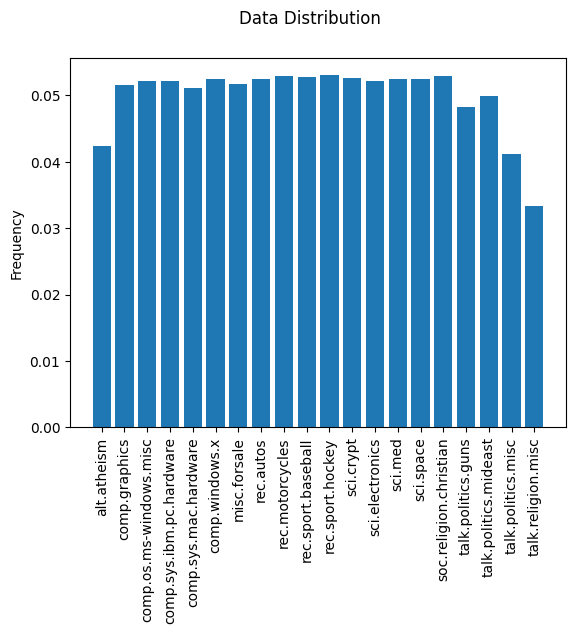

In [3]:
targets, frequency = np.unique(TNG_train.target, return_counts=True)
frequency = frequency/len(TNG_train.target)      # Normalizo
plt.bar(TNG_train.target_names,frequency)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.suptitle('Data Distribution')
plt.show()

Se puede observar que las clases se encuentran balanceadas.

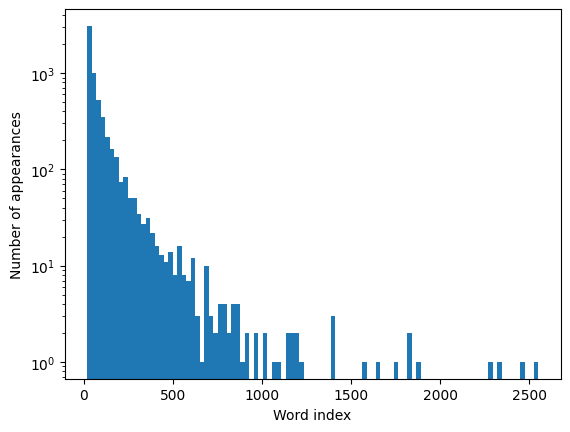

In [6]:
cv = TfidfVectorizer(max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)       #La matriz de documento-término

doc_freq = np.array(TNG_cv.astype(bool).sum(axis=0)).flatten()
plt.hist(doc_freq, bins=100,log=True)
plt.xlabel("Word index")
plt.ylabel("Number of appearances")
plt.show()

#1a - TDF-IDF

##Matriz Documento-Término

In [ ]:
cv = TfidfVectorizer(max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)       #La matriz de documento-término

In [ ]:
TNG_cv.shape

(11314, 6019)

In [ ]:
cv.get_feature_names_out()

array(['00', '000', '01', ..., 'zip', 'zone', 'zoom'], dtype=object)

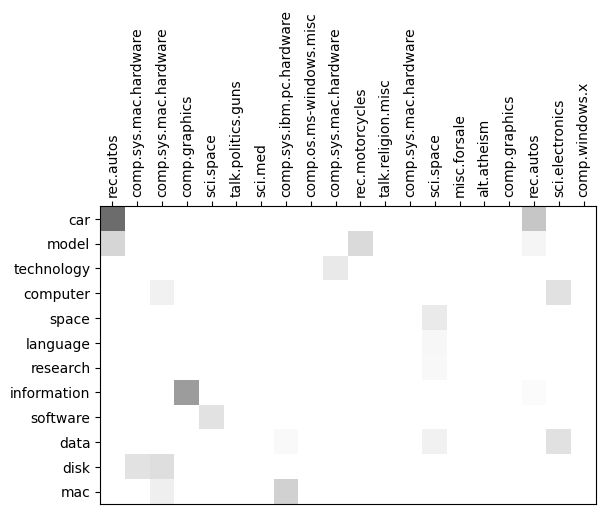

In [ ]:
reduced_doc=20
words = cv.get_feature_names_out()
helper.DTMatrix(words, TNG_train, TNG_cv, reduced_doc)

##Similitud coseno

In [ ]:
TNG_norm = (TNG_cv.toarray().T/(np.linalg.norm(TNG_cv.toarray(), axis=-1)+1e-8)).T
cosines = np.dot(TNG_norm[0], TNG_norm.T)
cosines

array([0.99999998, 0.0123958 , 0.06448783, ..., 0.        , 0.        ,
       0.03037182])

In [ ]:
docs_cmp = 150
helper.sim_cos(cosines, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.40156  rec.autos                  0.24838  rec.autos                  0.19177  rec.autos                 0.16300  comp.sys.mac.hardware      0.14345  rec.autos                
0.39225  rec.autos                  0.24289  rec.autos                  0.18958  rec.autos                 0.16198  misc.forsale               0.14344  rec.autos                
0.35485  rec.autos                  0.23293  rec.autos                  0.18767  rec.autos                 0.16176  rec.autos                  0.14322  rec.autos                
0.33482  rec.autos                  0.23058  rec.autos                  0.18662  rec.autos                 0.16107  comp.sys.mac.hardware      0.14261  rec.autos                
0.31303  rec.autos                  0.22813  rec.autos                  0.18525  rec.autos                 0.15923  rec.motorcycles            0.14222  sci.electronics          
0.31250  rec.autos              

##Bigrama

In [ ]:
cv2 = TfidfVectorizer(ngram_range=(1,2), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv2 = cv2.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv2.shape

(11314, 6577)

In [ ]:
docs_cmp = 50
TNG_norm2 = (TNG_cv2.toarray().T/(np.linalg.norm(TNG_cv2.toarray(), axis=-1)+1e-8)).T
cosines2 = np.dot(TNG_norm2[0], TNG_norm2.T)
helper.sim_cos(cosines2, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.39753  rec.autos                  0.29331  rec.autos                  0.26391  rec.autos                 0.24289  rec.autos                  0.21257  rec.autos                
0.39225  rec.autos                  0.29236  rec.autos                  0.26208  rec.autos                 0.23736  rec.autos                  0.21193  rec.autos                
0.34551  rec.autos                  0.28863  rec.motorcycles            0.25608  rec.autos                 0.23293  rec.autos                  0.21187  rec.autos                
0.33184  rec.autos                  0.28860  rec.autos                  0.25546  rec.autos                 0.22676  rec.autos                  0.21099  rec.motorcycles          
0.30688  rec.autos                  0.28358  rec.autos                  0.25505  rec.autos                 0.22500  rec.autos                  0.21097  rec.autos                
0.30613  rec.autos              

Se puede observar que la similitud coseno disminuyó levemente. Se llegó a la conclusión de que verdaderamente no aporta la utilización de bigramas en este caso.

##Trigrama

In [ ]:
cv3 = TfidfVectorizer(ngram_range=(1,3), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv3 = cv3.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv3.shape

(11314, 6613)

In [ ]:
docs_cmp = 50
TNG_norm3 = (TNG_cv3.toarray().T/(np.linalg.norm(TNG_cv3.toarray(), axis=-1)+1e-8)).T
cosines3 = np.dot(TNG_norm3[0], TNG_norm3.T)
helper.sim_cos(cosines3, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.39753  rec.autos                  0.29331  rec.autos                  0.26391  rec.autos                 0.24289  rec.autos                  0.21257  rec.autos                
0.39225  rec.autos                  0.29236  rec.autos                  0.26208  rec.autos                 0.23736  rec.autos                  0.21193  rec.autos                
0.34551  rec.autos                  0.28863  rec.motorcycles            0.25608  rec.autos                 0.23293  rec.autos                  0.21187  rec.autos                
0.33184  rec.autos                  0.28860  rec.autos                  0.25546  rec.autos                 0.22676  rec.autos                  0.21099  rec.motorcycles          
0.30688  rec.autos                  0.28358  rec.autos                  0.25505  rec.autos                 0.22500  rec.autos                  0.21097  rec.autos                
0.30613  rec.autos              

Se puede observar que se encuentra la misma cantidad de palabras que en la representación con hasta bigramas. Por lo tanto, no hay ningún trigrama relevante notorio en estos documentos.

##Cambio de threshold

In [ ]:
cv_th = TfidfVectorizer(max_df=1.0, min_df=80, max_features=None, stop_words="english")
TNG_cv_th = cv_th.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv_th.shape

(11314, 1697)

In [ ]:
docs_cmp = 50
TNG_norm_th = (TNG_cv_th.toarray().T/(np.linalg.norm(TNG_cv_th.toarray(), axis=-1)+1e-8)).T
cosines_th = np.dot(TNG_norm_th[0], TNG_norm_th.T)
helper.sim_cos(cosines_th, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.59767  rec.motorcycles            0.40461  rec.autos                  0.34902  sci.electronics           0.32377  rec.autos                  0.31347  rec.motorcycles          
0.50108  rec.autos                  0.40184  rec.autos                  0.34893  rec.autos                 0.32309  rec.autos                  0.31325  rec.autos                
0.47302  rec.autos                  0.38719  rec.autos                  0.34628  rec.autos                 0.32203  rec.motorcycles            0.31321  rec.autos                
0.46746  rec.autos                  0.38331  alt.atheism                0.34416  rec.autos                 0.32190  rec.autos                  0.30792  rec.autos                
0.45673  rec.autos                  0.36951  talk.politics.misc         0.34063  rec.autos                 0.31972  rec.autos                  0.30431  rec.autos                
0.43708  rec.autos              

No solo aumentó la similitud, sino que también hubo una mejora en el aspecto de relación, ya que se relaciona al documento actual con más de su tipo que antes. Por lo tanto aumentar la cantidad de veces que una palabra debe aparecer para considerársela relevante, resultó efectivo.

In [ ]:
cv_th2 = TfidfVectorizer(max_df=0.04, min_df=20, max_features=None, stop_words="english")
TNG_cv_th2 = cv_th2.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv_th2.shape

(11314, 5877)

In [ ]:
docs_cmp = 50
TNG_norm_th2 = (TNG_cv_th2.toarray().T/(np.linalg.norm(TNG_cv_th2.toarray(), axis=-1)+1e-8)).T
cosines_th2 = np.dot(TNG_norm_th2[0], TNG_norm_th2.T)
helper.sim_cos(cosines_th2, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.43831  rec.autos                  0.32620  rec.autos                  0.28980  rec.autos                 0.26477  rec.autos                  0.23436  rec.autos                
0.42351  rec.autos                  0.31999  rec.autos                  0.28765  rec.autos                 0.26302  rec.autos                  0.23255  rec.autos                
0.38501  rec.autos                  0.31637  rec.autos                  0.28733  rec.autos                 0.26243  rec.autos                  0.23224  rec.autos                
0.35237  rec.autos                  0.31537  rec.autos                  0.28369  misc.forsale              0.26219  rec.autos                  0.23148  rec.autos                
0.34369  talk.politics.misc         0.30945  rec.autos                  0.27996  rec.autos                 0.25585  rec.autos                  0.23015  rec.autos                
0.33940  rec.autos              

Modificar la frecuencia máxima de aparición de un término para ser descartado no trajo mejoras. Solo se hizo notoria al disminuirla enormemente. Sin embargo, esto se considera un empeoramiento.

#1b - CountVectorizer

##Matriz Documento-Término

In [ ]:
cv = CountVectorizer(max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv.shape

(11314, 6019)

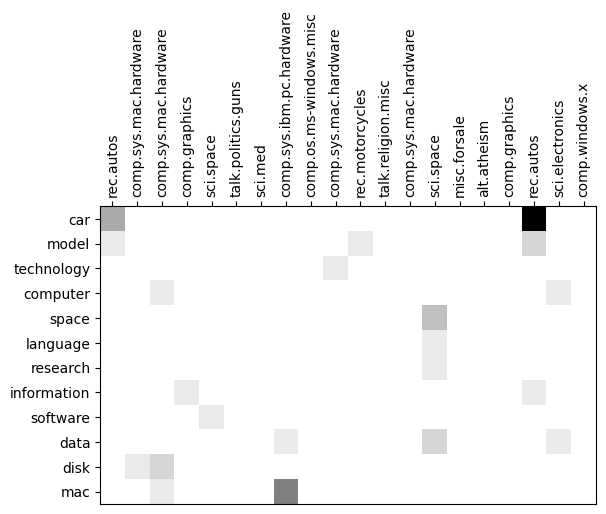

In [ ]:
reduced_doc=20
words = cv.get_feature_names_out()
helper.DTMatrix(words, TNG_train, TNG_cv, reduced_doc)

##Similitud coseno

In [ ]:
TNG_norm = (TNG_cv.toarray().T/(np.linalg.norm(TNG_cv.toarray(), axis=-1)+1e-8)).T
cosines = np.dot(TNG_norm[0], TNG_norm.T)
cosines

array([1.        , 0.0211952 , 0.09869275, ..., 0.        , 0.        ,
       0.02686077])

In [ ]:
docs_cmp = 150
helper.sim_cos(cosines, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.45661  rec.autos                  0.29096  rec.autos                  0.23817  rec.autos                 0.20620  rec.autos                  0.17817  misc.forsale             
0.45175  rec.autos                  0.28700  alt.atheism                0.23757  misc.forsale              0.20574  sci.electronics            0.17817  rec.motorcycles          
0.41473  rec.autos                  0.28365  rec.autos                  0.23747  sci.electronics           0.20324  rec.autos                  0.17817  rec.autos                
0.40993  rec.autos                  0.28201  rec.autos                  0.23538  rec.autos                 0.20294  rec.autos                  0.17817  rec.sport.hockey         
0.40370  rec.autos                  0.28135  rec.motorcycles            0.23474  rec.motorcycles           0.20247  rec.autos                  0.17817  rec.sport.hockey         
0.39036  rec.motorcycles        

La similitud aumentó respecto al uso de TDF-IDF. Sin embargo la confusión entre documentos de distintos tipos no se modificó. Por lo tanto, no se puede considerar realmente una mejora.

##Bigrama

In [ ]:
cv2 = CountVectorizer(ngram_range=(1,2), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv2 = cv2.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv2.shape

(11314, 6577)

In [ ]:
docs_cmp = 50
TNG_norm2 = (TNG_cv2.toarray().T/(np.linalg.norm(TNG_cv2.toarray(), axis=-1)+1e-8)).T
cosines2 = np.dot(TNG_norm2[0], TNG_norm2.T)
helper.sim_cos(cosines2, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.45661  rec.autos                  0.35635  alt.atheism                0.31652  rec.autos                 0.29096  rec.autos                  0.27201  rec.motorcycles          
0.44751  rec.autos                  0.35512  rec.autos                  0.31497  rec.autos                 0.28700  alt.atheism                0.27003  rec.autos                
0.40867  rec.autos                  0.35371  rec.autos                  0.31053  sci.electronics           0.28135  rec.motorcycles            0.26886  rec.autos                
0.40789  rec.autos                  0.34471  rec.autos                  0.30952  rec.autos                 0.28124  rec.autos                  0.26622  rec.autos                
0.39682  rec.autos                  0.34348  rec.autos                  0.30861  rec.autos                 0.27954  rec.autos                  0.26452  rec.autos                
0.39036  rec.motorcycles        

No se observó mejora alguna. Por lo tanto, no hay ningún bigrama relevante notorio en estos documentos.

##Trigrama

In [ ]:
cv3 = CountVectorizer(ngram_range=(1,3), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv3 = cv3.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv3.shape

(11314, 6613)

In [ ]:
docs_cmp = 50
TNG_norm3 = (TNG_cv3.toarray().T/(np.linalg.norm(TNG_cv3.toarray(), axis=-1)+1e-8)).T
cosines3 = np.dot(TNG_norm3[0], TNG_norm3.T)
helper.sim_cos(cosines3, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.45661  rec.autos                  0.35635  alt.atheism                0.31652  rec.autos                 0.29096  rec.autos                  0.27201  rec.motorcycles          
0.44751  rec.autos                  0.35512  rec.autos                  0.31497  rec.autos                 0.28700  alt.atheism                0.27003  rec.autos                
0.40867  rec.autos                  0.35371  rec.autos                  0.31053  sci.electronics           0.28135  rec.motorcycles            0.26886  rec.autos                
0.40789  rec.autos                  0.34471  rec.autos                  0.30952  rec.autos                 0.28124  rec.autos                  0.26622  rec.autos                
0.39682  rec.autos                  0.34348  rec.autos                  0.30861  rec.autos                 0.27954  rec.autos                  0.26452  rec.autos                
0.39036  rec.motorcycles        

Se puede observar que se encuentra la misma cantidad de palabras que en la representación con hasta bigramas. Por lo tanto, no hay ningún trigrama relevante notorio en estos documentos.

##Cambio de threshold

In [ ]:
cv_th = CountVectorizer(max_df=1.0, min_df=80, max_features=None, stop_words="english")
TNG_cv_th = cv_th.fit_transform(TNG_train.data)       #La matriz de documento-término
TNG_cv_th.shape

(11314, 1697)

In [ ]:
docs_cmp = 50
TNG_norm_th = (TNG_cv_th.toarray().T/(np.linalg.norm(TNG_cv_th.toarray(), axis=-1)+1e-8)).T
cosines_th = np.dot(TNG_norm_th[0], TNG_norm_th.T)
helper.sim_cos(cosines_th, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.58038  rec.motorcycles            0.43259  alt.atheism                0.37463  rec.autos                 0.34684  alt.atheism                0.32787  rec.autos                
0.50871  rec.autos                  0.42656  rec.autos                  0.37280  rec.autos                 0.34684  sci.electronics            0.32501  rec.autos                
0.50077  rec.autos                  0.41761  rec.autos                  0.35909  rec.autos                 0.34472  rec.motorcycles            0.32444  rec.autos                
0.49161  rec.autos                  0.41037  rec.autos                  0.35410  misc.forsale              0.34412  rec.autos                  0.32444  rec.autos                
0.48525  rec.autos                  0.40493  rec.autos                  0.35410  sci.electronics           0.34412  rec.autos                  0.32444  rec.autos                
0.47271  rec.autos              

No solo aumentó la similitud, sino que también hubo una mejora en el aspecto de relación, ya que se relaciona al documento actual con más de su tipo que antes. Por lo tanto, aumentar la cantidad de veces que una palabra debe aparecer para considerársela relevante, resultó efectivo.

#2 - Truncated SVD

##TDF-IDF

In [ ]:
cv = TfidfVectorizer(ngram_range=(1,2), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)
TNG_cv.shape

(11314, 6577)

In [ ]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = red.fit_transform(TNG_cv)
TNG_cv_red.shape

(11314, 300)

In [ ]:
TNG_norm = (TNG_cv_red.T/(np.linalg.norm(TNG_cv_red, axis=-1)+1e-8)).T
cosines = np.dot(TNG_norm[0], TNG_norm.T)

helper.sim_cos(cosines, TNG_train, docs_cmp=50)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.74269  rec.motorcycles            0.66271  rec.autos                  0.60464  rec.autos                 0.56132  rec.autos                  0.53358  rec.autos                
0.71461  rec.autos                  0.65804  rec.autos                  0.59290  rec.autos                 0.55645  rec.autos                  0.53279  rec.autos                
0.70467  rec.autos                  0.65769  rec.autos                  0.59288  rec.autos                 0.55316  rec.autos                  0.53227  rec.autos                
0.70181  rec.autos                  0.65735  rec.autos                  0.59131  rec.autos                 0.54903  rec.autos                  0.53167  misc.forsale             
0.69857  rec.autos                  0.64700  rec.autos                  0.58645  rec.autos                 0.54870  rec.autos                  0.52629  rec.autos                
0.67721  rec.autos              

Se puede obsevar que al realizar la reducción de dimensionalidad, aumentó notablemente la similitud coseno.

###Cambio de threshold

In [ ]:
cv_th = TfidfVectorizer(ngram_range=(1,2), max_df=0.5, min_df=100, max_features=None, stop_words="english")
TNG_cv_th = cv_th.fit_transform(TNG_train.data)

red = TruncatedSVD(n_components=300)
TNG_cv_red_th = red.fit_transform(TNG_cv_th)

TNG_norm_th = (TNG_cv_red_th.T/(np.linalg.norm(TNG_cv_red_th, axis=-1)+1e-8)).T
cosines = np.dot(TNG_norm_th[0], TNG_norm_th.T)

helper.sim_cos(cosines, TNG_train, docs_cmp=50)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.73168  rec.motorcycles            0.65208  rec.autos                  0.59233  rec.autos                 0.54366  rec.autos                  0.53478  rec.autos                
0.71682  rec.autos                  0.65050  alt.atheism                0.58962  rec.autos                 0.54190  rec.autos                  0.53151  rec.autos                
0.71009  rec.autos                  0.64754  rec.autos                  0.57460  rec.autos                 0.54184  rec.autos                  0.52882  rec.autos                
0.69824  rec.autos                  0.63331  rec.autos                  0.56382  rec.autos                 0.54178  rec.autos                  0.52550  sci.electronics          
0.69372  rec.autos                  0.61308  rec.autos                  0.55703  talk.politics.misc        0.54147  rec.autos                  0.52239  rec.autos                
0.68969  rec.autos              

Se puede observar como este cambio de threshold produjo una mejora en el aspecto de relación, ya que se relaciona al documento actual con mas de su tipo que antes.

###Cambio de número de componentes

In [ ]:
cv_nc = TfidfVectorizer(ngram_range=(1,2), max_df=0.7, min_df=20, max_features=None, stop_words="english")
TNG_cv_nc = cv_nc.fit_transform(TNG_train.data)

red = TruncatedSVD(n_components=30)
TNG_cv_red_nc = red.fit_transform(TNG_cv_nc)

TNG_norm_nc = (TNG_cv_red_nc.T/(np.linalg.norm(TNG_cv_red_nc, axis=-1)+1e-8)).T
cosines = np.dot(TNG_norm_nc[0], TNG_norm_nc.T)


docs_cmp = 50
helper.sim_cos(cosines, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.97813  rec.autos                  0.95647  rec.autos                  0.94406  rec.autos                 0.92200  rec.autos                  0.90709  rec.autos                
0.97037  rec.autos                  0.95551  rec.autos                  0.94276  rec.autos                 0.91588  rec.autos                  0.90556  rec.autos                
0.96714  rec.autos                  0.95484  rec.autos                  0.94085  rec.autos                 0.91579  rec.autos                  0.90409  rec.autos                
0.96369  rec.autos                  0.95405  rec.autos                  0.93970  rec.autos                 0.91576  sci.electronics            0.89860  rec.motorcycles          
0.96175  rec.autos                  0.95148  rec.autos                  0.93472  rec.autos                 0.91231  rec.autos                  0.89708  rec.autos                
0.96105  rec.autos              

No solo aumentó la similitud enormemente, sino que también hubo una mejora en el aspecto de relación, ya que se relaciona al documento actual con más de su tipo que antes. Por lo que trabajar con una dimensionalidad más reducida, en este caso  produjo una gran mejora.

In [ ]:
feature_names = cv_nc.get_feature_names_out()

components = red.components_

for i, component in enumerate(components):
    top_features_idx = component.argsort()[::-1][:10]  # Tomar los índices de las 10 mejores características
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(f"Componente {i+1}: {top_features}")

Componente 1: ['don', 'just', 'like', 'know', 'people', 'think', 'does', 'good', 'use', 'time']
Componente 2: ['windows', 'thanks', 'card', 'drive', 'dos', 'file', 'mail', 'use', 'files', 'advance']
Componente 3: ['geb', 'gordon banks', 'pitt edu', 'intellect geb', 'geb cadre', 'cadre dsl', 'shameful surrender', 'edu shameful', 'dsl pitt', 'dsl']
Componente 4: ['god', 'jesus', 'does', 'windows', 'thanks', 'bible', 'christ', 'faith', 'christians', 'christian']
Componente 5: ['key', 'chip', 'encryption', 'government', 'clipper', 'keys', 'use', 'public', 'law', 'escrow']
Componente 6: ['drive', 'scsi', 'drives', 'disk', 'hard', 'ide', 'key', 'controller', 'chip', 'card']
Componente 7: ['god', '00', 'edu', '10', 'sale', 'new', 'jesus', 'com', 'space', 'key']
Componente 8: ['windows', 'file', 'window', 'dos', 'files', 'problem', 'program', 'running', 'using', 'use']
Componente 9: ['key', 'game', 'god', 'chip', 'team', 'does', 'games', 'clipper', 'keys', 'encryption']
Componente 10: ['car', 

Estos son algunos valores de las distintas componentes que se obtuvieron al reducir la dimensionalidad. Allí se puede observar cierta relación entre los términos.

##CountVectorizer

In [ ]:
cv = CountVectorizer(ngram_range=(1,2), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)
TNG_cv.shape

(11314, 6577)

In [ ]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = red.fit_transform(TNG_cv)
TNG_cv_red.shape

(11314, 300)

In [ ]:
TNG_norm = (TNG_cv_red.T/(np.linalg.norm(TNG_cv_red, axis=-1)+1e-8)).T
cosines = np.dot(TNG_norm[0], TNG_norm.T)
cosines

docs_cmp = 50
helper.sim_cos(cosines, TNG_train, docs_cmp)

Documento elegido: 
	 rec.autos
Mayoes similitud coseno con otros documentos:
0.78709  rec.autos                  0.73320  rec.autos                  0.65581  rec.autos                 0.61397  rec.autos                  0.58842  rec.autos                
0.77718  rec.autos                  0.72522  rec.motorcycles            0.65450  rec.autos                 0.61050  talk.politics.misc         0.58708  rec.autos                
0.77611  rec.autos                  0.72362  rec.autos                  0.65048  rec.autos                 0.61004  sci.electronics            0.57870  rec.sport.hockey         
0.77281  rec.autos                  0.71698  rec.autos                  0.64025  rec.autos                 0.60990  rec.autos                  0.57839  rec.autos                
0.75728  rec.autos                  0.71492  rec.autos                  0.63787  rec.autos                 0.60899  rec.autos                  0.57760  rec.autos                
0.75416  rec.autos              

Se puede obsevar que al realizar la reducción de dimensionalidad, aumentó notablemente la similitud coseno. Incluso hubo una mejora respecto a la realización con TDF-IDF.

#3 - Matriz término-documento

In [ ]:
cv = TfidfVectorizer(ngram_range=(1,2), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)
TNG_cv.shape

(11314, 6577)

In [ ]:
TNG_cv_trn = np.transpose(TNG_cv)
TNG_cv_trn.shape

(6577, 11314)

In [ ]:
svd = TruncatedSVD(n_components=100)
TNG_reduced = svd.fit_transform(TNG_cv_trn)

In [ ]:
selected_word='circuit'
selected_term_index = list(cv.get_feature_names_out()).index(selected_word)
TNG_tr_norm = (TNG_reduced.T/(np.linalg.norm(TNG_reduced, axis=-1)+1e-8)).T
cosines = np.dot(TNG_tr_norm[selected_term_index], TNG_tr_norm.T)
cosines

array([ 0.00308337,  0.09510134,  0.03907857, ..., -0.06521584,
        0.08592683,  0.01036373])

In [ ]:
print("Término elegido:\n\t", cv.get_feature_names_out()[selected_term_index])

print("Similitud con otros términos:")
# Obtener los índices de los términos más similares (excluyendo el término seleccionado)
similar_term_indices = np.argsort(cosines)[-61:-1][::-1]
similar_term_names = [cv.get_feature_names_out()[i] for i in similar_term_indices]

num_columns = 3
num_rows = len(similar_term_indices) // num_columns

for i in range(num_rows):
    row_terms = similar_term_names[i*num_columns: (i+1)*num_columns]
    row_cosines = cosines[similar_term_indices[i*num_columns: (i+1)*num_columns]]
    row_output = "".join("\t{:.5f}  {:<25}".format(cosine, term) for cosine, term in zip(row_cosines, row_terms))
    print(row_output)


Término elegido:
	 circuit
Similitud con otros términos:
	0.83623  voltage                  	0.77667  volt                     	0.76478  circuits                 
	0.76443  resistor                 	0.74553  frequency                	0.73003  analog                   
	0.72674  audio                    	0.72656  signal                   	0.72644  input                    
	0.72629  electronics              	0.72166  electrical               	0.71618  amp                      
	0.70076  current                  	0.69506  ttl                      	0.68558  signals                  
	0.68270  wiring                   	0.67140  output                   	0.66415  wire                     
	0.65437  components               	0.64110  noise                    	0.63867  frequencies              
	0.63503  balanced                 	0.62829  flow                     	0.62755  transmitter              
	0.62674  relay                    	0.62337  inputs                   	0.62318  powered        

##Utilizando NearestNeighbors

In [ ]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = red.fit_transform(TNG_cv.T)
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_cv_red)

In [ ]:
idx_1 = cv.vocabulary_["circuit"]
dist, neig = neigh.kneighbors(TNG_cv_red[idx_1:idx_1+1])
for n,d in zip(neig[0],dist[0]):
    print(f"{round(1-d,5):<10}{cv.get_feature_names_out()[n]}")

1.0       circuit
0.66248   voltage
0.61631   circuits
0.57153   resistor
0.55774   electronics
0.50519   frequency
0.50397   volt
0.4987    relay
0.49473   input
0.49092   output
0.48345   analog
0.44853   generator
0.44458   electrical
0.44391   amp
0.41819   current
0.41439   signals
0.41352   detect
0.41136   rf
0.40589   design
0.39962   ct


Se puede notar que hay cierta diferencia entre calcular la similitud coseno a mano y utilizando NearestNeighbors. Sin embargo, ambas formas son aceptables.

#4 - Matriz término-clase

##Cálculo de matriz

In [ ]:
cv = CountVectorizer(ngram_range=(1,2), max_df=1.0, min_df=20, max_features=None, stop_words="english")
TNG_cv = cv.fit_transform(TNG_train.data)
TNG_cv.shape

(11314, 6577)

In [ ]:
TNG_cv_array = TNG_cv.toarray()
term_class_matrix = np.zeros((TNG_cv_array.shape[1], len(np.unique(TNG_train.target))))

for doc_idx, term_idx in zip(*TNG_cv.nonzero()):
    term_class_matrix[term_idx, TNG_train.target[doc_idx]] += TNG_cv_array[doc_idx, term_idx]
term_class_matrix_normalized = term_class_matrix / np.max(term_class_matrix, axis=0, keepdims=True) #Normalizo

term_class_matrix_normalized.shape

(6577, 20)

In [ ]:
idx = cv.vocabulary_["car"]
cv.get_feature_names_out()[idx]

'car'

In [ ]:
term_idx_sort = np.argsort(term_class_matrix_normalized[idx])[::-1]
class_sort = [TNG_train.target_names[i] for i in term_idx_sort]
class_sort

['rec.autos',
 'rec.motorcycles',
 'sci.electronics',
 'misc.forsale',
 'talk.politics.mideast',
 'talk.politics.guns',
 'alt.atheism',
 'talk.politics.misc',
 'talk.religion.misc',
 'rec.sport.hockey',
 'sci.crypt',
 'comp.sys.ibm.pc.hardware',
 'sci.med',
 'comp.windows.x',
 'sci.space',
 'soc.religion.christian',
 'comp.sys.mac.hardware',
 'comp.os.ms-windows.misc',
 'comp.graphics',
 'rec.sport.baseball']

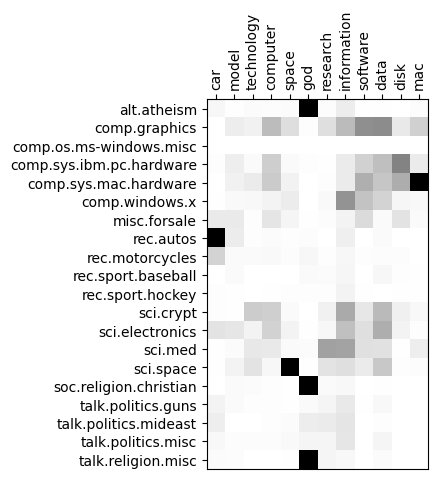

In [ ]:
selected_words = [
    "car",
    "model",
    "technology",
    "computer",
    "space",
    "god",
    "research",
    "information",
    "software",
    "data",
    "disk",
    "mac"
]
words=cv.get_feature_names_out()
selected_word_indices = [words.tolist().index(word) for word in selected_words]
reduced_matrix = term_class_matrix_normalized[selected_word_indices,:]
reduced_matrix = np.transpose(reduced_matrix)

plt.imshow(1-reduced_matrix, cmap='gray', vmin=0, vmax=1)
plt.xticks(range(len(selected_words)), selected_words, rotation=90)
plt.yticks(range(len(np.unique(TNG_train.target))), np.unique(TNG_train.target_names))
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

plt.show()

##Similitud coseno

In [ ]:
neigh = NearestNeighbors(n_neighbors=25, metric="cosine")
neigh.fit(term_class_matrix_normalized)

In [ ]:
idx_1 = cv.vocabulary_["car"]
dist, neig = neigh.kneighbors(term_class_matrix_normalized[idx_1:idx_1+1])
for n,d in zip(neig[0],dist[0]):
    print(f"{round(1-d,5):<10}{cv.get_feature_names_out()[n]}")

1.0       car
0.99626   cars
0.98987   ford
0.98928   trunk
0.9868    brake
0.98465   alarm
0.9798    gt
0.97425   toyota
0.97266   vw
0.97164   trucks
0.97125   sho
0.96802   dodge
0.9578    mileage
0.95558   brakes
0.95523   autos
0.94709   tires
0.93198   chrysler
0.92884   maintenance
0.9262    civic
0.91716   engine
0.91705   driving
0.91445   wheel
0.91444   drove
0.90617   mx
0.90411   wheels


Se puede observar como la similitud entre distintos términos resultó ser enorme (y correcta) al separarlos por clase.

#5 - Matriz término-término

Se decidió eliminar de antemano las stop-words, para luego evitar inconvenientes.

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Preprocesamiento para eliminar stopwords antes del tokenizado
filtered_texts = []
for text in TNG_train.data:
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_texts.append(' '.join(filtered_words))

##Cálculo de matriz

In [6]:
max_words=10000
V=max_words+1
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(filtered_texts)
seqs=tokenizer.texts_to_sequences(filtered_texts)
print(len(seqs), len(filtered_texts))

11314 11314


In [7]:
counts_matrix=lil_matrix((V-1, V-1))
counts_matrix.shape

(10000, 10000)

In [8]:
seqs=np.hstack(seqs)
seqs=seqs.astype(int)
seqs.shape

(1296034,)

In [9]:
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=5, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)
len(pairs)

12958470

In [10]:
pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)
print ("Pairs: ",pairs_u.shape)
print ("Counts: ",counts.shape)

Pairs:  (5101133, 2)
Counts:  (5101133,)


In [11]:
for num,(pair,count) in enumerate(zip(pairs_u, counts)):
    if num%1000 ==0:
        print(f'\r{num}', end="")
    counts_matrix[pair[0],pair[1]] += count

5101000

In [12]:
red = TruncatedSVD(n_components=300)
TNG_matrix_red = red.fit_transform(counts_matrix.T)
TNG_matrix_red.shape

(10000, 300)

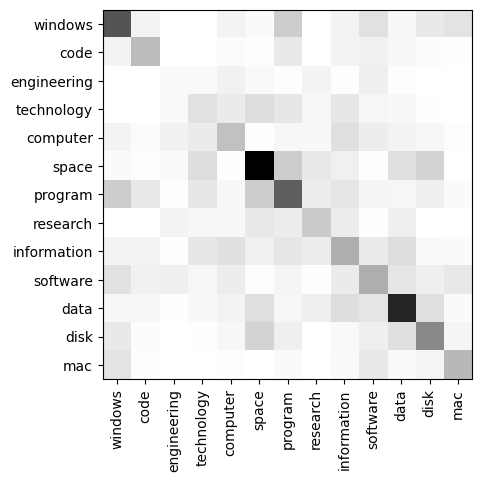

In [18]:
# Definir las palabras seleccionadas
selected_words = [
    "windows",
    "code",
    "engineering",
    "technology",
    "computer",
    "space",
    "program",
    "research",
    "information",
    "software",
    "data",
    "disk",
    "mac"
]

selected_word_indices = [tokenizer.word_index[word] for word in selected_words]
term_term_matrix = counts_matrix[selected_word_indices, :][:, selected_word_indices].toarray()

plt.imshow(1-term_term_matrix, cmap='gray')
plt.xticks(range(len(selected_words)), selected_words, rotation=90)
plt.yticks(range(len(selected_words)), selected_words)
plt.show()

##Similitud coseno - Window size=5

In [23]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_matrix_red)
idx_1 = tokenizer.word_index["car"]
dist, neig = neigh.kneighbors(TNG_matrix_red[idx_1:idx_1+1])
for n,d in zip(neig[0],dist[0]):
    print(f"{round(1-d,5):<10}{tokenizer.index_word[n]}")

1.0       car
0.86419   cars
0.84963   dealer
0.84184   driving
0.82325   accident
0.81135   bike
0.80697   engine
0.80244   volvo
0.80026   oil
0.7883    buy
0.78576   ford
0.78244   tires
0.78217   rear
0.78086   passenger
0.77928   toyota
0.77893   wheels
0.77714   road
0.77638   front
0.77471   selling
0.77448   tire


##Test de analogía

In [59]:
from sklearn.preprocessing import normalize

neigh = NearestNeighbors(n_neighbors=15, metric="cosine")
neigh.fit(TNG_matrix_red)

idx_1 = tokenizer.word_index["man"]
idx_2 = tokenizer.word_index["father"]
idx_3 = tokenizer.word_index["woman"]

vector = TNG_matrix_red[idx_2] - TNG_matrix_red[idx_1] + TNG_matrix_red[idx_3]

dist, neig = neigh.kneighbors([vector])
for n,d in zip(neig[0],dist[0]):
    if (tokenizer.index_word[n] not in ["man", "woman", "father"]):
        print(f"{round(1-d,5):<10}{tokenizer.index_word[n]}")

0.55291   proceeds
0.52479   bayonet
0.50343   bullets
0.47175   son
0.41041   stabbed
0.33697   holy
0.32892   spirit
0.30756   hasan
0.28262   father's
0.27089   beaten
0.26081   burnt
0.25799   slaughtered
0.23567   godhead
0.21328   essence


Se puede observar que el resultado del test de analogía es muy malo.

##Similitud coseno - Window size=10

In [25]:
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=10, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)
pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)
for num,(pair,count) in enumerate(zip(pairs_u, counts)):
    counts_matrix[pair[0],pair[1]] += count
red = TruncatedSVD(n_components=300)
TNG_matrix_red = red.fit_transform(counts_matrix.T)

neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_matrix_red)
idx_1 = tokenizer.word_index["car"]
dist, neig = neigh.kneighbors(TNG_matrix_red[idx_1:idx_1+1])
for n,d in zip(neig[0],dist[0]):
    print(f"{round(1-d,5):<10}{tokenizer.index_word[n]}")

1.0       car
0.89272   dealer
0.88865   cars
0.86742   driving
0.85345   ford
0.84676   volvo
0.83722   tires
0.83535   accident
0.83372   rear
0.82627   passenger
0.82514   bought
0.82358   wheels
0.82019   engine
0.81694   nissan
0.81024   replaced
0.80999   front
0.80373   oil
0.80316   owner
0.80311   miles
0.79711   selling


Se puede notar un aumento en la similitud respecto al caso anterior.

##Similitud coseno - Window size=20

In [8]:
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=20, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)
pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)
for num,(pair,count) in enumerate(zip(pairs_u, counts)):
    counts_matrix[pair[0],pair[1]] += count
red = TruncatedSVD(n_components=300)
TNG_matrix_red = red.fit_transform(counts_matrix.T)

neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_matrix_red)
idx_1 = tokenizer.word_index["car"]
dist, neig = neigh.kneighbors(TNG_matrix_red[idx_1:idx_1+1])
for n,d in zip(neig[0],dist[0]):
    print(f"{round(1-d,5):<10}{tokenizer.index_word[n]}")

1.0       car
0.92872   cars
0.91294   dealer
0.89084   driving
0.87458   tires
0.86916   volvo
0.86838   ford
0.86645   maintenance
0.86368   passenger
0.8636    rear
0.85936   owner
0.85795   alarm
0.85709   mileage
0.85512   wheel
0.85455   wheels
0.85354   toyota
0.84943   nissan
0.84925   civic
0.84795   miles
0.84523   front


Se puede notar una gran mejora en la similitud y en las palabras con las que se realiza la relación. Sin embargo, se requiere de mucho tiempo de procesamiento y de mucha memoria ram, debido a que el tamaño de la ventana es mucho mayor.

##Similitud coseno - Window size=1

In [9]:
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=1, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)
pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)
for num,(pair,count) in enumerate(zip(pairs_u, counts)):
    counts_matrix[pair[0],pair[1]] += count
red = TruncatedSVD(n_components=300)
TNG_matrix_red = red.fit_transform(counts_matrix.T)

neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_matrix_red)
idx_1 = tokenizer.word_index["car"]
dist, neig = neigh.kneighbors(TNG_matrix_red[idx_1:idx_1+1])
for n,d in zip(neig[0],dist[0]):
    print(f"{round(1-d,5):<10}{tokenizer.index_word[n]}")

1.0       car
0.92646   cars
0.91367   dealer
0.89864   driving
0.88302   tires
0.8773    passenger
0.87104   volvo
0.86841   ford
0.86666   owner
0.86552   rear
0.86424   maintenance
0.86003   wheels
0.85521   bought
0.85317   toyota
0.85292   honda
0.84915   alarm
0.84581   front
0.84358   wheel
0.84176   accident
0.84088   civic


Sorprendentemente, al igual que el tamaño de ventana anterior, se obtuvo una gran mejoría y con un costo computacional muy pequeño, considerándoselo el mejor resultado hasta el momento.

#6 - Matriz PPMI

##Cálculo de matriz

In [31]:
epsilon = 1e-8  #Para no tener indeterminaciones

In [32]:
prob_marg = counts_matrix[1:,1:].sum(axis=1)/counts_matrix[1:,1:].sum() #Probabilidad marginal
prob_marg.shape

(9999, 1)

In [33]:
probs = counts_matrix[1:,1:]/counts_matrix[1:,1:].sum() #Probabilidad total
probs.shape

(9999, 9999)

In [34]:
PMI = probs/(np.dot(prob_marg,prob_marg.T))
PMI=np.array(PMI)
PMI=PMI*(PMI>1)+1e-8
PMI = np.log(PMI)
PMI

array([[  2.83498863, -18.42068074, -18.42068074, ..., -18.42068074,
        -18.42068074, -18.42068074],
       [-18.42068074,   2.418169  ,   2.21867156, ..., -18.42068074,
        -18.42068074, -18.42068074],
       [-18.42068074,   2.21867156,   3.2228364 , ..., -18.42068074,
        -18.42068074, -18.42068074],
       ...,
       [-18.42068074, -18.42068074, -18.42068074, ...,   6.92005974,
        -18.42068074, -18.42068074],
       [-18.42068074, -18.42068074, -18.42068074, ..., -18.42068074,
        -18.42068074, -18.42068074],
       [-18.42068074, -18.42068074, -18.42068074, ..., -18.42068074,
        -18.42068074, -18.42068074]])

In [35]:
PPMI = PMI*(PMI>0) + 1e-8
PPMI

array([[2.83498864e+00, 1.00000000e-08, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 2.41816901e+00, 2.21867157e+00, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 2.21867157e+00, 3.22283641e+00, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       ...,
       [1.00000000e-08, 1.00000000e-08, 1.00000000e-08, ...,
        6.92005975e+00, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 1.00000000e-08, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 1.00000000e-08, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08]])

In [36]:
red = TruncatedSVD(n_components=300)
TNG_PPMI_red = red.fit_transform(PPMI)
TNG_PPMI_red.shape

(9999, 300)

##Similitud coseno - Window size=5

In [20]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_PPMI_red)
idx_1 = tokenizer.word_index["car"]-1
dist, neig = neigh.kneighbors(TNG_PPMI_red[idx_1:idx_1+1])
for d,n in zip(dist[0], neig[0]):
    print(f"{round(1-d,5):<10}{tokenizer.index_word[n+1]}")

1.0       car
0.80431   cars
0.67822   tires
0.67807   miles
0.6748    bike
0.65195   engine
0.64929   toyota
0.64437   honda
0.63552   dealer
0.63263   back
0.62674   like
0.62403   up
0.6237    bought
0.62351   ford
0.62311   around
0.62281   front
0.61903   rear
0.61745   brakes
0.61684   buy
0.61072   truck


##Test de analogía

In [69]:
from sklearn.preprocessing import normalize

neigh = NearestNeighbors(n_neighbors=7, metric="cosine")
neigh.fit(TNG_PPMI_red)

idx_1 = tokenizer.word_index["man"]-1
idx_2 = tokenizer.word_index["father"]-1
idx_3 = tokenizer.word_index["woman"]-1

vector = TNG_PPMI_red[idx_2] - TNG_PPMI_red[idx_1] + TNG_PPMI_red[idx_3]

dist, neig = neigh.kneighbors([vector])
for n,d in zip(neig[0],dist[0]):
    if (tokenizer.index_word[n+1] not in ["man", "woman", "father"]):
        print(f"{round(1-d,5):<10}{tokenizer.index_word[n+1]}")

0.67932   mother
0.65663   maria
0.64869   daughter
0.62312   aunt
0.61935   husband


Realmente se puede apreciar un empeoramiento en relación con las similitudes anteriores. Sin embargo, ahora se comienzan a cumplir los test de analogía de manera perfecta.